### What is this notebook for? ###

The main purpose of this notebook is buiding Liquidity's probability model for the Otodom.pl, category "apartments for rent".

**Prerequisities:** "ml_dataset_otodompl.tsv". Can be obtained with `2.QualityDriversDataPrep-Otodom.ipynb`

**Output:**

* Stored model: `xgb_otodom_rent_02.pkl`
* Average price for city/rooms_num: `avg_city_price_otodom_rent_02.csv`
* Model columns name: `model_columns_xgb_otodom_rent_02.pkl`

In [1]:
import pandas as pd
import numpy as np

from sklearn.externals import joblib
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
otodom_full = pd.read_csv("ml_dataset_otodompl.tsv", sep ="\t")

Select only listings in category 102, apartments for rent.

In [4]:
otodom_full = otodom_full[otodom_full['category_id'] == 102]

We will train our model on Jun-Nov data:

In [5]:
otodom_train_full = otodom_full[otodom_full['month'] !=12]

Data validation on December data:

In [6]:
otodom_test_full = otodom_full[otodom_full['month'] ==12]

In [7]:
def create_liquid_field(dataframe):
    dataframe['unique_senders'] = dataframe['unique_senders'].fillna(0).astype('int')
    dataframe['liquid'] = (dataframe['unique_senders'] >= 3).astype('int')
    return dataframe

In [8]:
def select_category(dataframe, category_id):
    dataframe = dataframe[dataframe['category_id'] == category_id]
    return dataframe

In [9]:
def filter_currency(dataframe, currency):
    dataframe = dataframe[dataframe['price[currency]'] == currency]
    return dataframe

In [10]:
def select_columns(dataframe, columns):
    dataframe = dataframe[columns]
    return dataframe

In [11]:
columns = ['ad_id', 
           'city_id', 
           'street_name', 
           'title', 
           'is_paid_for_post',
           'was_paid_for_post',
           'description', 
           'mysql_search_rooms_num', 
           'mysql_search_m', 
           'mysql_search_price', 
           'build_year', 
           'building_floors_num',  
           'building_material', 
           'building_type',
           'construction_status', 
           'equipment_types', 
           'extras_types', 
           'floor_no',
           'rent_to_students',
           'heating', 
           'private_business', 
           'media_types',  
           'security_types', 
           'windows_type',
           'unique_senders',
           'n_images']

In [12]:
def filter_values(dataframe, col, values_list):
    dataframe = dataframe[dataframe[col].isin(values_list)]
    return dataframe

In [13]:
def remove_outliers(dataframe, col, lower_bound, upper_bound):
    dataframe = dataframe[(dataframe[col] >= lower_bound) & (dataframe[col] <= upper_bound)]
    return dataframe

In [14]:
def add_avg_price_city_ap_type(dataframe):
    city_n = pd.DataFrame({'city_n': dataframe.groupby(['city_id'])['ad_id'].nunique()}).reset_index()
    city_room_avg_price = pd.DataFrame({'avg_price': dataframe.groupby(['city_id', 'mysql_search_rooms_num'])['mysql_search_price'].mean()}).reset_index()
    dataframe = dataframe.merge(city_n, on='city_id', how='left')
    dataframe = dataframe.merge(city_room_avg_price, on = ['city_id', 'mysql_search_rooms_num'], how='left')
    #dataframe = dataframe[dataframe["city_n"] >= 30]
    dataframe = dataframe.drop('ad_id', axis=1)
    return dataframe


In [15]:
def count_avg_price_city_ap_type(dataframe):
    city_n = pd.DataFrame({'city_n': dataframe.groupby(['city_id'])['ad_id'].nunique()}).reset_index()
    city_room_avg_price = pd.DataFrame({'avg_price': dataframe.groupby(['city_id', 'mysql_search_rooms_num'])['mysql_search_price'].mean()}).reset_index()
    return city_room_avg_price

In [16]:
def add_higher_city_room_avg(dataframe):
    dataframe['higher_city_room_mean'] = (dataframe['mysql_search_price'] > dataframe['avg_price']).astype('int')
    return dataframe

In [17]:
def private_business_binarization(dataframe):
    dataframe.private_business = dataframe.private_business.replace({'private': 1, 'business':0})
    dataframe.private_business = dataframe.private_business.fillna('no_info')
    return dataframe

In [18]:
def column_info(dataframe, col, new_column_name, drop=False):
    dataframe[new_column_name] = pd.notnull(dataframe[col]).astype('int')
    if drop:
        dataframe = dataframe.drop(col, axis=1)
    return dataframe

In [19]:
def media_types_processing(dataframe):
    mt_test = dataframe.media_types.fillna("no_media")
    all_categories = []
    
    vals = mt_test.value_counts().index.tolist()
    
    
    for v in vals:
        possible_values = v.split("<->")
        for x in possible_values:
            if x not in all_categories:
                all_categories.append(x)
            
    categories = mt_test.apply(lambda x: x.split("<->"))
    
    for x in all_categories:
        print(x)
        dataframe[x] = categories.map(lambda current: x in current).astype('int')
    return dataframe
    

In [20]:
def equipment_types_processing(dataframe):
    mt_test = dataframe.equipment_types.fillna("no_equipment")
    all_categories = []
    
    vals = mt_test.value_counts().index.tolist()
    
    
    for v in vals:
        possible_values = v.split("<->")
        for x in possible_values:
            if x not in all_categories:
                all_categories.append(x)
            
    categories = mt_test.apply(lambda x: x.split("<->"))
    
    for x in all_categories:
        print(x)
        dataframe[x] = categories.map(lambda current: x in current).astype('int')
    return dataframe

In [21]:
def security_types_processing(dataframe):
    mt_test = dataframe.security_types.fillna("no_security")
    all_categories = []
    
    vals = mt_test.value_counts().index.tolist()
    
    
    for v in vals:
        possible_values = v.split("<->")
        for x in possible_values:
            if x not in all_categories:
                all_categories.append(x)
            
    categories = mt_test.apply(lambda x: x.split("<->"))
    
    for x in all_categories:
        print(x)
        dataframe[x] = categories.map(lambda current: x in current).astype('int')
    return dataframe
    

In [22]:
def extras_types_processing(dataframe):
    mt_test = dataframe.extras_types.fillna("no_extras")
    all_categories = []
    
    vals = mt_test.value_counts().index.tolist()
    
    
    for v in vals:
        possible_values = v.split("<->")
        for x in possible_values:
            if x not in all_categories:
                all_categories.append(x)
            
    categories = mt_test.apply(lambda x: x.split("<->"))
    
    for x in all_categories:
        print(x)
        dataframe[x] = categories.map(lambda current: x in current).astype('int')
    return dataframe

In [23]:
def create_construction_decade(dataframe):
    dataframe['construction_year_decade'] = dataframe['build_year'].fillna(0)\
    .apply(lambda year: year if (year > 1000 and year < 2030) else 0)\
    .apply(lambda year: year // 10)
    dataframe = dataframe.drop('build_year', axis=1)
    return dataframe

In [24]:
def market_primary_binarization(dataframe):
    dataframe['market_primary'] = dataframe['market'].replace({'primary': 1, 'secondary':0})
    dataframe['market_primary'] = dataframe.market_primary.fillna('no_info')
    dataframe = dataframe.drop('market', axis=1)
    return dataframe

In [25]:
def create_avg_price_diff(dataframe, avg_price_col, price_col, new_column_name):
    dataframe[new_column_name] = (dataframe[price_col] - dataframe[avg_price_col])/dataframe[avg_price_col]
    return dataframe

In [26]:
otodom_train_rent = otodom_train_full.pipe(filter_currency, currency = 'PLN')\
.pipe(select_columns, columns=columns)\
.pipe(create_liquid_field)\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(filter_values, col='mysql_search_rooms_num', values_list=['0', '1', '2', '3', '4', '5', '6'])\
.pipe(remove_outliers, col='mysql_search_price', lower_bound=900, upper_bound=6500)\
.pipe(add_avg_price_city_ap_type)\
.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='build_year', new_column_name='construction_year_info')\
.pipe(create_construction_decade)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(media_types_processing)\
.pipe(equipment_types_processing)\
.pipe(security_types_processing)\
.pipe(extras_types_processing)\
.pipe(column_info, col='extras_types', new_column_name='extras_types_info', drop=True)\
.pipe(column_info, col='media_types', new_column_name='media_types_info', drop=True)\
.pipe(column_info, col='security_types', new_column_name='security_types_info', drop=True)\
.pipe(column_info, col='equipment_types', new_column_name='equipment_types_info', drop=True)\
.pipe(column_info, col='heating', new_column_name='heating_info', drop=False)\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')


no_media
cable-television
internet
phone
0
no_equipment
furniture
dishwasher
fridge
oven
stove
tv
washing_machine
0
no_security
entryphone
monitoring
anti_burglary_door
0
closed_area
alarm
roller_shutters
no_extras
balcony
lift
garage
basement
0
separate_kitchen
usable_room
terrace
air_conditioning
non_smokers_only
garden
two_storey


In [27]:
otodom_test_rent = otodom_test_full.pipe(filter_currency, currency = 'PLN')\
.pipe(select_columns, columns=columns)\
.pipe(create_liquid_field)\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(filter_values, col='mysql_search_rooms_num', values_list=['0', '1', '2', '3', '4', '5', '6'])\
.pipe(remove_outliers, col='mysql_search_price', lower_bound=900, upper_bound=6500)\
.pipe(add_avg_price_city_ap_type)\
.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='build_year', new_column_name='construction_year_info')\
.pipe(create_construction_decade)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(media_types_processing)\
.pipe(equipment_types_processing)\
.pipe(security_types_processing)\
.pipe(extras_types_processing)\
.pipe(column_info, col='extras_types', new_column_name='extras_types_info', drop=True)\
.pipe(column_info, col='media_types', new_column_name='media_types_info', drop=True)\
.pipe(column_info, col='security_types', new_column_name='security_types_info', drop=True)\
.pipe(column_info, col='equipment_types', new_column_name='equipment_types_info', drop=True)\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')


no_media
cable-television
internet
phone
0
no_equipment
furniture
dishwasher
fridge
oven
stove
tv
washing_machine
0
no_security
monitoring
entryphone
anti_burglary_door
closed_area
0
roller_shutters
alarm
no_extras
balcony
garage
lift
basement
0
separate_kitchen
usable_room
terrace
non_smokers_only
air_conditioning
garden
two_storey


In [28]:
for col in otodom_train_rent:
    print(col)

city_id
title
is_paid_for_post
was_paid_for_post
description
mysql_search_rooms_num
mysql_search_m
mysql_search_price
building_floors_num
building_material
building_type
construction_status
floor_no
rent_to_students
heating
private_business
windows_type
unique_senders
n_images
liquid
city_n
avg_price
higher_city_room_mean
construction_year_info
construction_year_decade
street_info
no_media
cable-television
internet
phone
0
no_equipment
furniture
dishwasher
fridge
oven
stove
tv
washing_machine
no_security
entryphone
monitoring
anti_burglary_door
closed_area
alarm
roller_shutters
no_extras
balcony
lift
garage
basement
separate_kitchen
usable_room
terrace
air_conditioning
non_smokers_only
garden
two_storey
extras_types_info
media_types_info
security_types_info
equipment_types_info
heating_info
price_diff


In [29]:
cat_columns = [
                  'mysql_search_rooms_num',
                  'building_material',
                  'building_type',
                  'construction_status',
                  'floor_no',
                  'windows_type', 
                  'rent_to_students',
                   'heating']

In [30]:
otodom_train_rent[cat_columns] = otodom_train_rent[cat_columns].fillna('no_info').astype('str')
otodom_test_rent[cat_columns] = otodom_test_rent[cat_columns].fillna('no_info').astype('str')

In [31]:
train_dataset = pd.get_dummies(otodom_train_rent)
test_dataset = pd.get_dummies(otodom_test_rent)

In [32]:
num_columns = ['title', 'description', 'mysql_search_m', 'mysql_search_price', 'building_floors_num', 'n_images', 'avg_price']

In [33]:
train_dataset[num_columns] = train_dataset[num_columns].fillna(0)
test_dataset[num_columns] = test_dataset[num_columns].fillna(0)

In [34]:
y = train_dataset['liquid']
y_cv = test_dataset['liquid']

In [35]:
X = train_dataset.drop(['liquid', 'unique_senders', 'city_n'], axis=1)
X_cv = test_dataset.drop(['liquid', 'unique_senders', 'city_n'], axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=432)

In [37]:
ratio = float(np.sum(y == 0)) / np.sum(y == 1)
ratio

2.228410055310058

In [38]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth':7,
    'learning_rate': 0.1,
    'silent': False,
    'min_child_weight': 9,
    'subsample': 0.8, 
    'colsample_bytree': 0.8,
    'scale_pos_weight': ratio,
    'n_estimators': 2500
}



In [39]:
clf = XGBClassifier(**default_params)

In [40]:
clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        eval_metric='logloss', 
        verbose=False, early_stopping_rounds=10)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=9, missing=None, n_estimators=2500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=2.228410055310058, seed=0, silent=False,
       subsample=0.8)

In [41]:
joblib.dump(clf, 'xgb_otodom_rent_02.pkl') 
#clf = joblib.load('xgb_otodom_rent_02.pkl') 

['xgb_otodom_rent_02.pkl']

In [42]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

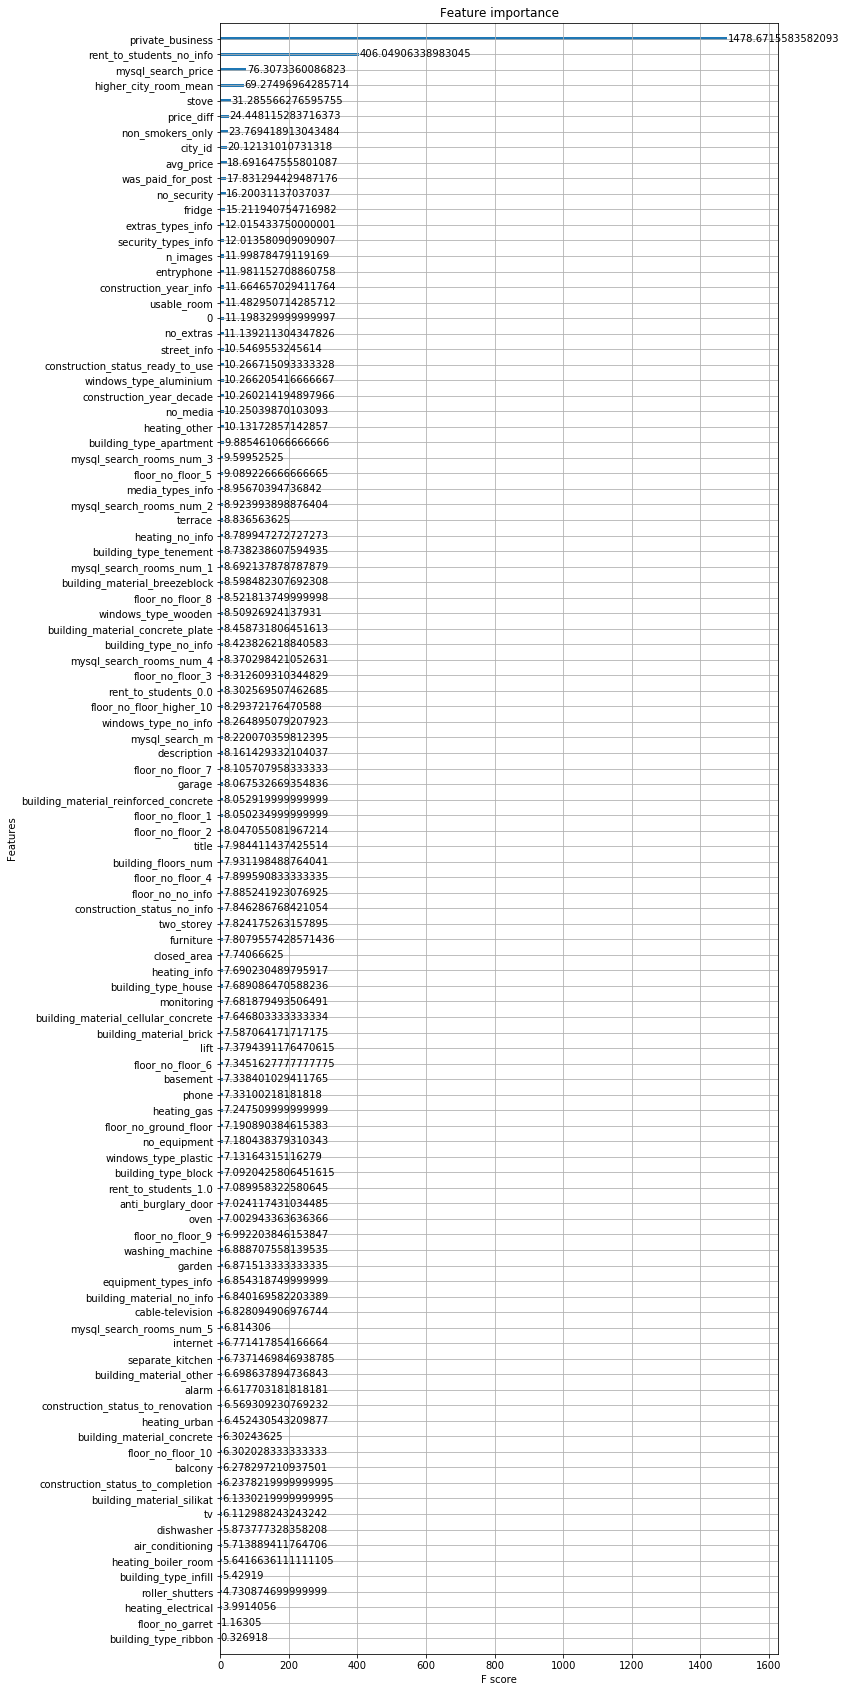

In [43]:
my_plot_importance(clf, figsize=(10, 30),  importance_type='gain' )

**Validation on train:**

In [44]:
y_train_predict = clf.predict(X_train)

In [45]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_train, y_train_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_train,  y_train_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_train,  y_train_predict)))
print('F1: {0:.2f}'.format(f1_score(y_train,  y_train_predict)))

Accuracy: 0.86
Precision: 0.73
Recall: 0.84
F1: 0.78


In [46]:
pd.crosstab(
    pd.Series(y_train, name='Actual'),
    pd.Series(y_train_predict, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,All
Actual,,,
0.0,26087,14508,40595
1.0,13772,7701,21473
All,39859,22209,62068


In [47]:
print(classification_report(y_train, y_train_predict))

             precision    recall  f1-score   support

          0       0.93      0.86      0.89     57211
          1       0.73      0.84      0.78     25527

avg / total       0.87      0.86      0.86     82738



**Validation on test:**

In [48]:
y_val_predict = clf.predict(X_test)

In [49]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_val_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_val_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_val_predict)))
print('F1: {0:.2f}'.format(f1_score(y_test, y_val_predict)))

Accuracy: 0.81
Precision: 0.68
Recall: 0.77
F1: 0.72


In [50]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_val_predict, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,All
Actual,,,
0.0,2326,1346,3672
1.0,2028,1159,3187
All,4354,2505,6859


In [51]:
print(classification_report(y_test, y_val_predict))

             precision    recall  f1-score   support

          0       0.89      0.83      0.86     18936
          1       0.68      0.77      0.72      8644

avg / total       0.82      0.81      0.82     27580



**Validation on December data:**

In [52]:
for col in X.columns:
    if col not in X_cv.columns:
        print(col)
        X_cv[col] = 0

heating_info


In [53]:
for col in X_cv.columns:
    if col not in X.columns:
        print(col)
        X_cv = X_cv.drop(col, axis=1)

In [54]:
selected_columns = X.columns 

In [55]:
y_cv_predict = clf.predict(X_cv[selected_columns])

In [56]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_cv,  y_cv_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_cv,  y_cv_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_cv,  y_cv_predict)))
print('F1: {0:.2f}'.format(f1_score(y_cv,  y_cv_predict)))

Accuracy: 0.82
Precision: 0.65
Recall: 0.78
F1: 0.71


In [57]:
pd.crosstab(
    pd.Series(y_cv, name='Actual'),
    pd.Series(y_cv_predict, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,7186,1459,8645
1,746,2673,3419
All,7932,4132,12064


In [58]:
print(classification_report(y_cv, y_cv_predict))

             precision    recall  f1-score   support

          0       0.91      0.83      0.87      8645
          1       0.65      0.78      0.71      3419

avg / total       0.83      0.82      0.82     12064



In [59]:
from eli5 import show_weights
show_weights(clf)

Weight,Feature
0.5062,private_business
0.1390,rent_to_students_no_info
0.0261,mysql_search_price
0.0237,higher_city_room_mean
0.0107,stove
0.0084,price_diff
0.0081,non_smokers_only
0.0069,city_id
0.0064,avg_price
0.0061,was_paid_for_post


For usage model as a service we need to store:

* average price for city_id/rooms_num combination
* model columns 
* model

**Average price for city_id/rooms_num combination**

In [60]:
avg_city = otodom_full.pipe(create_liquid_field)\
.pipe(select_category, category_id = 102)\
.pipe(filter_currency, currency = 'PLN')\
.pipe(select_columns, columns=columns)\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(filter_values, col='mysql_search_rooms_num', values_list=['0', '1', '2', '3', '4', '5', '6'])\
.pipe(count_avg_price_city_ap_type)


In [61]:
avg_city.to_csv("avg_city_price_otodom_rent_02.csv", index=None)

**Save model columns**

In [62]:
model_columns = list(X_train.columns)
joblib.dump(model_columns, 'model_columns_xgb_otodom_rent_02.pkl')

['model_columns_xgb_otodom_rent_02.pkl']

### Example how it works as a service ###

In [63]:
data = {"city_id": 26, 
        "mysql_search_rooms_num": 3, 
        "mysql_search_m": 88, 
        "mysql_search_price": 2000,
        "mysql_search_price_per_m": 50,
        "title": 30,
        "description": 1786,
        "rent_to_students": 1,
        "private_business": "business",
        "street_name" : "Chorzovska",
        "build_year" : 2000,
        "building_floors_num": 5, 
        "building_material": "brick",
        "construction_status": "ready_to_use",
        "extras_types": "balcony<->garage<->lift<->separate_kitchen",
        "heating": "urban",
        "media_types": "cable-television<->internet",
        "security_types": "monitoring",
        "windows_type": "wooden"
    }

In [64]:
def get_dataframe(json):
    df = pd.DataFrame.from_dict([dict(json)])
    return df

In [65]:
t1 = get_dataframe(data)

In [66]:
df_avg_city_prices = pd.read_csv("avg_city_price_otodom_rent_02.csv")

In [67]:
df_avg_city_prices.mysql_search_rooms_num = df_avg_city_prices.mysql_search_rooms_num.astype('int')
t1.mysql_search_rooms_num = t1.mysql_search_rooms_num.astype('int')

In [68]:
df_aggregated = pd.merge(t1, df_avg_city_prices, on=['city_id', 'mysql_search_rooms_num'])

In [69]:
df_aggregated

,build_year,building_floors_num,building_material,city_id,construction_status,description,extras_types,heating,media_types,mysql_search_m,mysql_search_price,mysql_search_price_per_m,mysql_search_rooms_num,private_business,rent_to_students,security_types,street_name,title,windows_type,avg_price
0,2000,5,brick,26,ready_to_use,1786,balcony<->garage<->lift<->separate_kitchen,urban,cable-television<->internet,88,2000,50,3,business,1,monitoring,Chorzovska,30,wooden,4370.744431


In [70]:
model_columns = [
           'city_id', 
           'street_name', 
           'title', 
           'description', 
           'mysql_search_rooms_num', 
           'mysql_search_m', 
           'mysql_search_price', 
           'build_year', 
           'building_floors_num',  
           'building_material', 
           'building_type',
           'construction_status', 
           'equipment_types', 
           'extras_types', 
           'floor_no',
           'rent_to_students',
           'heating', 
           'private_business', 
           'media_types',  
           'security_types', 
           'windows_type',
           'n_images']

In [71]:
for col in model_columns:
    if col not in df_aggregated.columns:
        print(col)
        df_aggregated[col] = None

building_type
equipment_types
floor_no
n_images


In [72]:
df_aggregated = df_aggregated.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='build_year', new_column_name='construction_year_info')\
.pipe(create_construction_decade)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(media_types_processing)\
.pipe(equipment_types_processing)\
.pipe(security_types_processing)\
.pipe(extras_types_processing)\
.pipe(column_info, col='extras_types', new_column_name='extras_types_info', drop=True)\
.pipe(column_info, col='media_types', new_column_name='media_types_info', drop=True)\
.pipe(column_info, col='security_types', new_column_name='security_types_info', drop=True)\
.pipe(column_info, col='equipment_types', new_column_name='equipment_types_info', drop=True)\
.pipe(column_info, col='heating', new_column_name='heating_info', drop=False)\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')


cable-television
internet
no_equipment
monitoring
balcony
garage
lift
separate_kitchen


In [73]:
df_aggregated[cat_columns] = df_aggregated[cat_columns].fillna('no_info').astype('str')

In [74]:
df_aggregated[num_columns] = df_aggregated[num_columns].fillna(0)

In [75]:
for col in X.columns:
    if col not in df_aggregated.columns:
        print(col)
        df_aggregated[col] = 0

is_paid_for_post
was_paid_for_post
no_media
phone
0
furniture
dishwasher
fridge
oven
stove
tv
washing_machine
no_security
entryphone
anti_burglary_door
closed_area
alarm
roller_shutters
no_extras
basement
usable_room
terrace
air_conditioning
non_smokers_only
garden
two_storey
mysql_search_rooms_num_1
mysql_search_rooms_num_2
mysql_search_rooms_num_3
mysql_search_rooms_num_4
mysql_search_rooms_num_5
mysql_search_rooms_num_6
building_material_breezeblock
building_material_brick
building_material_cellular_concrete
building_material_concrete
building_material_concrete_plate
building_material_hydroton
building_material_no_info
building_material_other
building_material_reinforced_concrete
building_material_silikat
building_material_wood
building_type_apartment
building_type_block
building_type_house
building_type_infill
building_type_loft
building_type_no_info
building_type_ribbon
building_type_tenement
construction_status_no_info
construction_status_ready_to_use
construction_status_to_compl

In [76]:
for col in df_aggregated.columns:
    if col not in X.columns:
        print(col)
        df_aggregated = df_aggregated.drop(col, axis=1)

building_material
construction_status
heating
mysql_search_price_per_m
mysql_search_rooms_num
rent_to_students
windows_type
building_type
floor_no


In [77]:
selected_columns = X_train.columns

In [78]:
clf.predict_proba(df_aggregated[selected_columns])

array([[0.5433407 , 0.45665932]], dtype=float32)

In [79]:
df_aggregated = df_aggregated[selected_columns]

In [80]:
from eli5 import show_prediction
show_prediction(clf, df_aggregated.iloc[0], show_feature_values=True, top=20)